In this notebook well see how we can use the concept of graph cuts to find the MAP of a distribution described by a MRF

First lets import the necessery modules and define the dataclasses we will use:

In [272]:
from dataclasses import dataclass, field
import time
from itertools import product

import numpy as np
from numpy.random import random, randn,randint
from matplotlib import pyplot as plt

import networkx as nx
from torchvision import datasets


@dataclass(frozen=True)
class NodeWithPos:
    value: float
    posx: int
    posy: int
    
    def __str__(self):
        return f'{self.posx:02d}_{self.posy:02d}'
    
    def pos(self):
        return self.posx, self.posy

@dataclass(frozen=True)
class SegmentationNode(NodeWithPos):   
    pass

@dataclass(frozen=True)
class ImageNode(NodeWithPos):
    pass
    
@dataclass(frozen=True)
class ClassNode(NodeWithPos):
    pass

def get_posdict(nodelist):
    return dict([(node, node.pos()) for node in nodelist])


First let us look at a 1d example to get an intuition of how this algorithm works

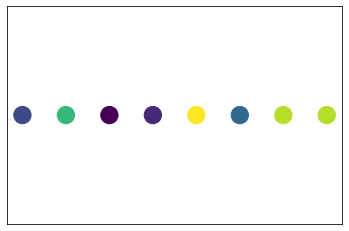

In [273]:
image_values = [0.2, 0.6, 0.0, 0.1, 0.9,0.3, 0.8, 0.8]
image_nodes = [ImageNode(c, i, 0) for i, c in enumerate(image_values)]
node_pos = dict([(node, node.pos()) for node in image_nodes])


graph = nx.Graph()
graph.add_nodes_from(image_nodes)
    
nx.draw_networkx_nodes(graph, get_posdict(image_nodes), image_nodes,
                       node_color=[n.value for n in image_nodes])


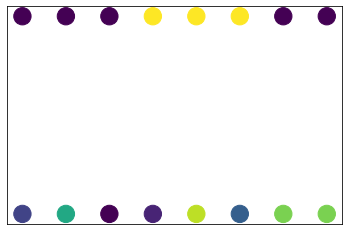

In [274]:
initial_guess = [(i//3) % 2 for i in range(len(image_values))] #000111000111...
segmentation_nodes = [SegmentationNode(c, i, 1)
                      for i, c in enumerate(initial_guess)]
node_pos.update(dict([(node, node.pos()) for node in image_nodes]))

nodelist = image_nodes + segmentation_nodes
nx.draw_networkx_nodes(graph, get_posdict(nodelist), nodelist,
                       node_color=[n.value for n in nodelist])


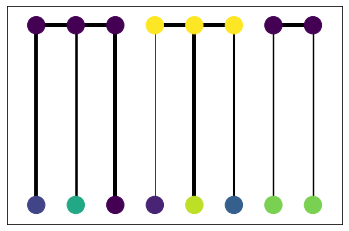

In [275]:
def similarity_energy(seg: NodeWithPos, img: NodeWithPos):
    return (1-(seg.value - img.value)**2)
    
def edge_energy(class0: int, class1: int, weight: float=1):
    return weight if class0 == class1 else 0


# add energy for being close to image
for img_node, seg_node in zip(image_nodes, segmentation_nodes):
    graph.add_edge(seg_node, img_node,
                   capacity=similarity_energy(seg_node, img_node))

# add energy for being close to neighbor
for seg1, seg2 in zip(segmentation_nodes[:-1], segmentation_nodes[1:]):
    graph.add_edge(seg1, seg2, 
                   capacity=edge_energy(seg1.value, seg2.value))

edges = graph.edges(data=True)
edge_witdh = [4*edge[2]['capacity'] for edge in edges]

nx.draw_networkx_nodes(graph, get_posdict(nodelist), nodelist,
                       node_color=[n.value for n in nodelist])
nx.draw_networkx_edges(graph, get_posdict(nodelist),
                       graph.edges, width=edge_witdh)


(0, 0, 0, 0, 1, 1, 1, 1)


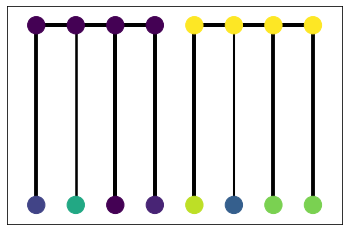

In [284]:
def brute_force_1d(img_node, weight=1):
    best_guess = (0, None, None)
    for guess in product(*[[0,1]]*len(image_values)):
        segmentation_nodes = [SegmentationNode(c, i, 1)
                            for i, c in enumerate(guess)]
        g = nx.Graph()
        for img_node, seg_node in zip(image_nodes, segmentation_nodes):
            g.add_edge(seg_node, img_node,
                        capacity=similarity_energy(seg_node, img_node))
            
        for seg1, seg2 in zip(segmentation_nodes[:-1], segmentation_nodes[1:]):
            g.add_edge(seg1, seg2,
                        capacity=edge_energy(seg1.value, seg2.value, weight))
        score = sum([edge[2]['capacity'] for edge in g.edges(data=True)])
        best_guess = best_guess if best_guess[0] > score else (score, guess, g)
    return best_guess

score, classes, graph = brute_force_1d(image_nodes)
print(classes)
nodelist = graph.nodes
edges = graph.edges(data=True)
edge_witdh = [4*edge[2]['capacity'] for edge in edges]

nx.draw_networkx_nodes(graph, get_posdict(nodelist), nodelist,
                       node_color=[n.value for n in nodelist])
nx.draw_networkx_edges(graph, get_posdict(nodelist),
                       graph.edges, width=edge_witdh)


In [277]:
class_0 = ClassNode(0)
class_1 = ClassNode(1)

graph = nx.Graph()
nodes = image_nodes + [class_0, class_1]
colors = [node.value for node in nodes]
node_pos[class_0] = (len(image_nodes)/2, -1)
node_pos[class_1] = (len(image_nodes)/2, 1)

# add energy for being close to image
for seg_node, img_node in zip(segmentation_nodes, image_nodes):
    class_ = class_0 if seg_node.value == 0 else class_1
    graph.add_edge(img_node, class_,
                   capacity=similarity_energy(img_node, class_))

# add energy for being close to neighbor
for i, (img1, img2) in enumerate(zip(image_nodes[:-1], image_nodes[1:])):                
    graph.add_edge(img1, img2, capacity=edge_energy(initial_guess[i], 
                                                    initial_guess[i+1], 
                                                    edge_weight))
    
edges = graph.edges(data=True)
print(len(edges))
edge_witdh = [4*edge[2]['capacity'] for edge in edges]

nx.draw_networkx_nodes(graph, node_pos, image_nodes + [class_0, class_1], 
                       node_color=colors)
nx.draw_networkx_edges(graph, node_pos, graph.edges, width=edge_witdh)


TypeError: __init__() missing 2 required positional arguments: 'posx' and 'posy'

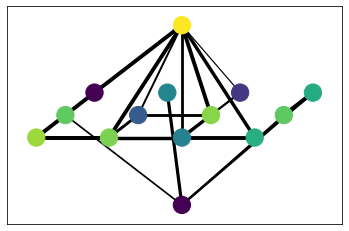

In [ ]:
img = random((4,3))
initial_guess = randint(0,2,img.shape)
image_nodes = np.array([ImageNode(value, i, j)
                      for (i, j), value in zip(np.ndindex(img.shape), img.ravel())
                      ]).reshape(img.shape)
graph = nx.Graph()
for node, con in zip(image_nodes.ravel(), initial_guess.ravel()):
    if con == 0:
        graph.add_edge(node, class_0,
                       capacity=similarity_energy(node, class_0))
    if con == 1:
        graph.add_edge(node, class_1,
                       capacity=similarity_energy(node, class_1))
for i, j in np.ndindex(img[:-1, :].shape):
    if not initial_guess[i, j] == initial_guess[i+1, j]:
        continue
    node1, node2 = image_nodes[i, j], image_nodes[i+1, j]
    graph.add_edge(node1, node2, capacity=similarity_energy(node1, node2))

for i, j in np.ndindex(img[:, :-1].shape):
    if not initial_guess[i, j] == initial_guess[i, j+1]:
        continue
    node1, node2 = image_nodes[i, j], image_nodes[i, j+1]
    graph.add_edge(node1, node2, capacity=similarity_energy(node1, node2))
    
node_pos = dict([(n, np.array([[1., 0.4],[0,1]])@n.pos()) 
                 for n in image_nodes.ravel()])
node_pos[class_0] = ((img.shape[0])/2, -3)
node_pos[class_1] = ((img.shape[0])/2, img.shape[1]+2)

edges = graph.edges(data=True)
edge_witdh = [4*edge[2]['capacity'] for edge in edges]
allnodes = list(image_nodes.ravel()) + [class_0, class_1]
node_color = [n.value for n in allnodes]
nx.draw_networkx_nodes(graph, node_pos, allnodes, node_color=node_color)
nx.draw_networkx_edges(graph, node_pos, graph.edges, edge_witdh)


In [ ]:
list(nx.all_neighbors(graph, image_nodes[0,0]))


[ClassNode(value=1),
 ImageNode(value=0.9391691139038945, posx=1, posy=0),
 ImageNode(value=0.9094578272623628, posx=0, posy=1)]